# Text Processing

In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style = 'whitegrid', palette = 'muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ['#01BEFE', 
                        '#FFDD00', 
                        '#FF7D00', 
                        '#FF006D',
                        '#ADFF02',
                        '#8F00FF'
                       ]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12,8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
#!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
#!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

In [3]:
df = pd.read_csv('reviews.csv')
df.head(5)

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [4]:
df.shape

(15746, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


C:\Users\lutha\Anaconda3\envs\data science\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'review score')

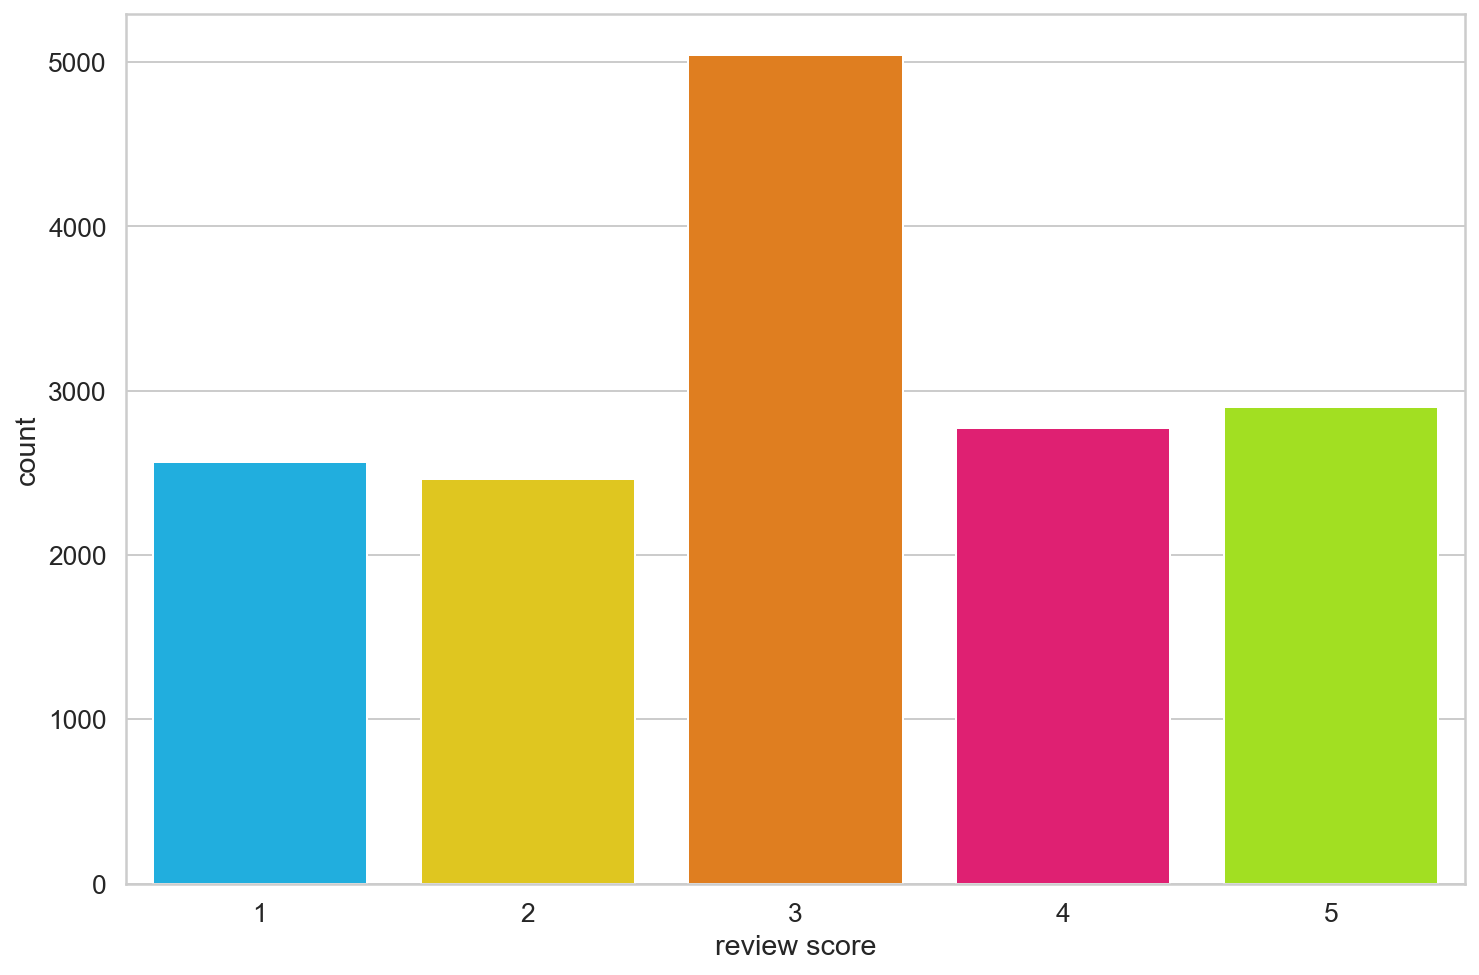

In [6]:
sns.countplot(df.score)
plt.xlabel('review score')

In [7]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating ==3:
        return 1
    else:
        return 2

In [8]:
df['sentiment'] = df.score.apply(to_sentiment)

In [9]:
class_names = ['negative', 'neutral', 'positive']

C:\Users\lutha\Anaconda3\envs\data science\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

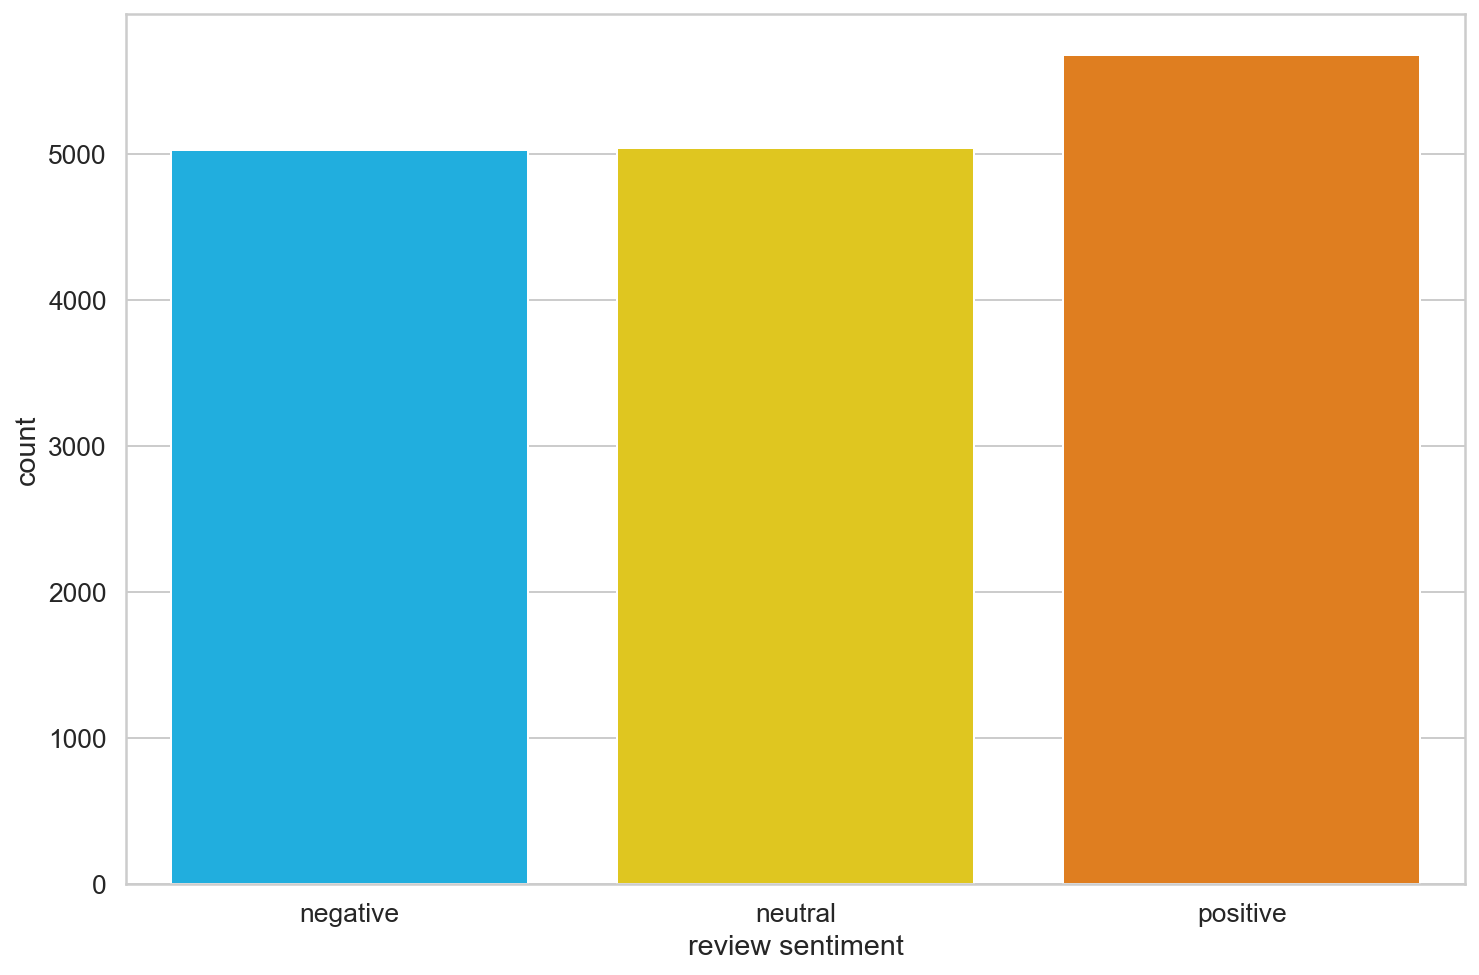

In [10]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing

In [11]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [12]:
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [13]:
sample_txt = "When was I last outside? I am stuck at home for 2 weeks."

In [14]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [15]:
print((len(token_ids),len(tokens)))

(15, 15)


## Special Tokens

In [16]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [17]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [18]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [19]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [20]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 32,
    add_special_tokens=True,
    return_token_type_ids = False,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\lutha\Anaconda3\envs\data science\lib\site-packages\transformers\tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [21]:
encoding['input_ids']

tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [22]:
len(encoding['input_ids'][0])

32

In [23]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

## Choosing Sequence Length

In [24]:
token_lens = []

for txt in df.content:
    tokens = tokenizer.encode(txt, max_length = 512)
    token_lens.append(len(tokens))

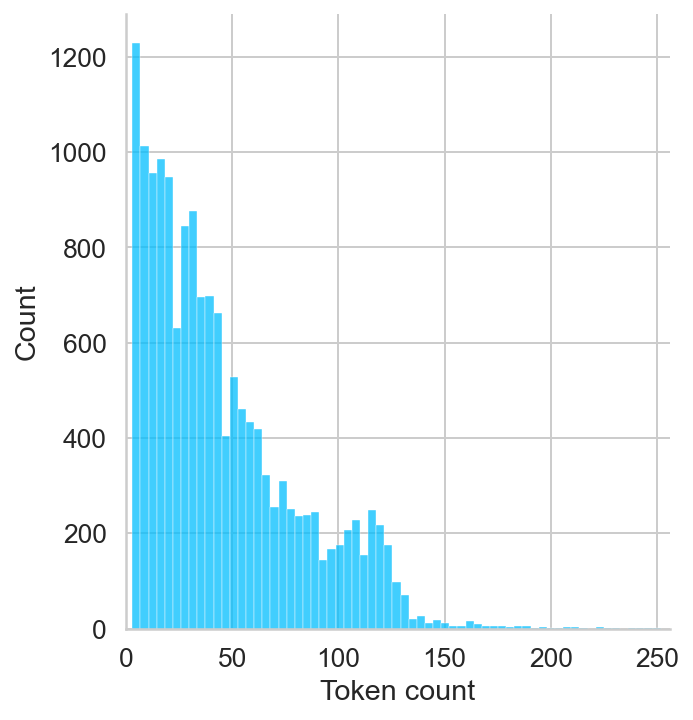

In [25]:
sns.displot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [26]:
MAX_LEN = 160

In [27]:
class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [28]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state = RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

In [29]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [30]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [31]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [32]:
data = next(iter(train_data_loader))
data.keys()

C:\Users\lutha\Anaconda3\envs\data science\lib\site-packages\transformers\tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [33]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([4, 160])
torch.Size([4, 160])
torch.Size([4])


# Text Classification

In [34]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [35]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'], 
    attention_mask=encoding['attention_mask'],
    return_dict=False
)

In [36]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [37]:
bert_model.config.hidden_size

768

In [38]:
pooled_output.shape

torch.Size([1, 768])

### Building a Semtiment Classifier

In [39]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            return_dict=False
        )
        
        output = self.drop(pooled_output)
        return self.out(output)

In [40]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [41]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([4, 160])
torch.Size([4, 160])


In [42]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4167, 0.1629, 0.4204],
        [0.5268, 0.1343, 0.3389],
        [0.3120, 0.1510, 0.5370],
        [0.5324, 0.1180, 0.3496]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

In [43]:
EPOCHS = 5

In [44]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias = False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [45]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )
        
        _, preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double()/n_examples, np.mean(losses)

In [46]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask
            )

            _, preds = torch.max(outputs, dim = 1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double()/n_examples, np.mean(losses)
            

%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(),'model.bin')
        best_accuracy = val_acc
    
    

In [47]:
#!gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

In [52]:
#model = SentimentClassifier(len(class_names))
#model.load_state_dict(torch.load('best_model_state.bin'))
#model = model.to(device)

In [53]:
def get_reviews(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            
            texts = d['review_text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask
            )

            _, preds = torch.max(outputs, dim = 1)
            
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return review_texts, predictions, prediction_probs, real_values


In [54]:
#test_acc, test_acc, = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

In [55]:
#y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [56]:
#print(classification_report(y_test, y_pred, target_names = class_names))

In [57]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot= True, fmt = 'd', cmap = 'Blue')
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha="right")
    plt.ylabel("True sentiment")
    plt.xlabel("Predicted sentiment")

In [58]:
#cm = confusion_matrix(y_test, y_pred)
#df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
#show_confusion_matrix(df_cm)

In [59]:
#idx = 2

#review_text = y_review_texts(idx)
#true_sendtiment = y_test(idx)

#pred_df = pd.DataFrame(
#    {
#        'class_names': class_names,
#        'values': y_pred_probs[idx]
#    }
#)

In [60]:
#print("\n".join(wrap(review_text)))
#print()
#print(f'True sentiment: {class_names[true_sentiment]}')

In [61]:
#sns.barplot(x = 'values', y = 'class_names', data = pred_df, orient = 'h')
#plt.ylabel('sentiment')
#plt.xlabel('probability')
#plt.xlim([0,1])